# Homework 5 - Evals for Failure Analysis with Phoenix

<center>
    <p style="text-align:left">
        <img alt="phoenix logo" src="https://repository-images.githubusercontent.com/564072810/f3666cdf-cb3e-4056-8a25-27cb3e6b5848" width="600"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>

## Launch Phoenix 

First, let's set up Phoenix on our local machine. You should run these commands within your terminal in your chosen environment.

(If you have already done this in a previous HW assignment, you are good to go.)

**Install Phoenix**

```pip install arize-phoenix```

**Boot up Phoenix on localhost**

```phoenix serve```

Run `phoenix serve` in your terminal to boot up Phoenix locally.

In [1]:
import json
from collections import Counter
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import phoenix as px
from phoenix.trace.dsl import SpanQuery

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os, getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Pipeline States

Below are the states of the recipe agent pipeline we are simulating, in order.

**ParseRequest** - LLM interprets and analyzes the user's query to understand what they're asking for

**PlanToolCalls** - LLM decides which tools to invoke and in what order based on the parsed request

**GenCustomerArgs** - LLM constructs JSON arguments for the customer profile database lookup

**GetCustomerProfile** - Executes the customer-profile tool to retrieve user preferences and dietary restrictions

**GenRecipeArgs** - LLM constructs JSON arguments for the recipe database search based on customer profile

**GetRecipes** - Executes the recipe-search tool to find relevant recipes matching the criteria

**GenWebArgs** - LLM constructs JSON arguments for web search to find additional cooking tips/information

**GetWebInfo** - Executes the web-search tool to retrieve supplementary cooking information

**ComposeResponse** - LLM drafts the final answer combining recipes and web information

**DeliverResponse** - Agent sends the composed response to the user

In [3]:
PIPELINE_STATES: List[str] = [
    "ParseRequest",
    "PlanToolCalls", 
    "GenCustomerArgs",
    "GetCustomerProfile",
    "GenRecipeArgs",
    "GetRecipes",
    "GenWebArgs",
    "GetWebInfo",
    "ComposeResponse",
]
STATE_INDEX = {s: i for i, s in enumerate(PIPELINE_STATES)}

In [8]:
%run generate_traces_phoenix.py

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: recipe-agent-hw5
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

Phoenix Instrumented Trace Generator
Generating 100 traces with Phoenix instrumentation...


Generating traces: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]

Trace generation completed!
Check Phoenix dashboard to view the detailed spans!


In [4]:
def load_traces() -> pd.DataFrame:
    query = SpanQuery().where("span_kind == 'AGENT'")
    traces_df = px.Client().query_spans(query, project_name='recipe-agent-hw5')
    return traces_df

# Load traces from Phoenix
print("Loading traces from Phoenix...")
traces_df = load_traces()

print(f"Successfully loaded {len(traces_df)} traces from Phoenix")
print(f"DataFrame shape: {traces_df.shape}")
print(f"Columns: {list(traces_df.columns)}")

# Display sample trace
if not traces_df.empty:
    print("\nSample trace:")
    print(traces_df.iloc[0])

Loading traces from Phoenix...
Successfully loaded 100 traces from Phoenix
DataFrame shape: (100, 14)
Columns: ['name', 'span_kind', 'parent_id', 'start_time', 'end_time', 'status_code', 'status_message', 'events', 'context.span_id', 'context.trace_id', 'attributes.openinference.span.kind', 'attributes.output.value', 'attributes.agent.name', 'attributes.input.value']

Sample trace:
name                                  RecipeBot_Conversation_689a0e8f-af17-4dc6-906f...
span_kind                                                                         AGENT
parent_id                                                                          None
start_time                                             2025-08-15 23:18:46.631116+00:00
end_time                                               2025-08-15 23:19:17.279528+00:00
status_code                                                                       UNSET
status_message                                                                         

/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.22.0) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


In [5]:
# Add Eval
import os, re
from phoenix.evals import llm_generate, OpenAIModel
from phoenix.trace import SpanEvaluations

with open("eval.txt", "r") as f:
    eval_prompt = f.read()

def parser(response: str, row_index: int) -> dict:
    """Parser function for evaluate_output evaluator"""
    failure_state = r'"failure_state":\s*"([^"]*)"'
    explanation = r'"explanation":\s*"([^"]*)"'
    failure_state_match = re.search(failure_state, response, re.IGNORECASE).group(1)
    explanation_match = re.search(explanation, response, re.IGNORECASE).group(1)
    return {
        "label": failure_state_match,
        "explanation": explanation_match
    }

eval_model = OpenAIModel(
    model="gpt-4o",
    model_kwargs={
        "response_format": {"type": "json_object"},
        "temperature": 0
    }
)

# Generate evaluations using llm_generate
failure_analysis = llm_generate(
    dataframe=traces_df,
    template=eval_prompt,
    model=eval_model,
    output_parser=parser,
    concurrency=10,
)

px.Client().log_evaluations(
    SpanEvaluations(eval_name="Failure State with Explanation", dataframe=failure_analysis)
)



🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.
llm_generate |██████████| 100/100 (100.0%) | ⏳ 02:02<00:00 |  1.22s/it
/Users/priyanjindal/recipe-chatbot/.venv/lib/python3.13/site-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (11.22.0) and client (11.18.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


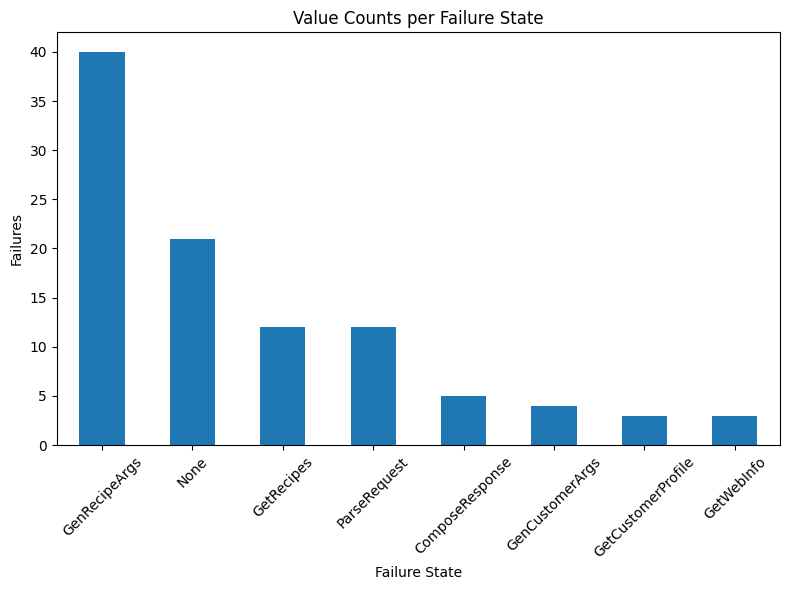

In [6]:
import matplotlib.pyplot as plt

# Example: assume failure_analysis["label"].value_counts() is already computed
counts = failure_analysis["label"].value_counts()

plt.figure(figsize=(8, 6))
counts.plot(kind="bar")

plt.title("Value Counts per Failure State")
plt.xlabel("Failure State")
plt.ylabel("Failures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Analysis of Failure State Distribution

The bar chart below shows how failures are distributed across the different pipeline states of the RecipeBot application. A few key insights stand out:

### Dominance of `GenRecipeArgs` Failures
- Approximately **40 failures** occurred at the `GenRecipeArgs` stage — by far the largest share.  
- This stage is the most schema-heavy and constraint-sensitive, since it must align **user intent, customer profile, and dietary rules** into structured JSON.  
- Even small misalignments can cause errors, such as:
  - Ignoring dietary requirements  
  - Mispopulating filters  
  - Producing queries inconsistent with the upstream profile  


### Healthy Share of Successful Runs
- The `"None"` category shows about **21 successful traces**, meaning no material defects were detected.  
- This indicates the pipeline is reasonably robust, with **roughly one-quarter to one-third of runs completing successfully** even under randomized defect injection.  


### Mid-Tier Failure States
- **ParseRequest (~12 failures)**  
  - Critical stage: if the query is misinterpreted, **all downstream reasoning is compromised**.  
- **GetRecipes (~12 failures)**  
  - Retrieval adds variability. Failures usually involve **irrelevant or malformed documents**.  

These represent **key failure points** that disrupt multiple downstream steps.  


### Lower-Frequency Failures
- States like **GenCustomerArgs**, **ComposeResponse**, **GetCustomerProfile**, **GetWebInfo**, and **PlanToolCalls** show only **1–4 failures each**.  
- These are less error-prone, likely because:
  - Their schemas are simpler  
  - Issues are easier to catch earlier  
  - Errors here have less systemic impact  


In [7]:
failure_analysis["trace"] = traces_df["attributes.output.value"]
failure_analysis

,label,explanation,trace
context.span_id,,,
1957ccf926c1749b,GenRecipeArgs,"In 'GenRecipeArgs', the 'servings' field is nu...","[{""role"": ""user"", ""content"": ""I need a gluten-..."
bf008174222fb1d7,GenRecipeArgs,The 'Generating recipe args' state fails to in...,"[{""role"": ""user"", ""content"": ""Suggest a health..."
856ae8251103749a,GenRecipeArgs,The 'Generating recipe args' state omits the '...,"[{""role"": ""user"", ""content"": ""I need a gluten-..."
3c6a0c8931720838,GenRecipeArgs,The 'GenRecipeArgs' state omits the 'servings'...,"[{""role"": ""user"", ""content"": ""I need a gluten-..."
1bb42c99a37634f3,GetCustomerProfile,The 'GetCustomerProfile' state introduces a fa...,"[{""role"": ""user"", ""content"": ""I need a gluten-..."
...,...,...,...
9a489b8cb794e866,GetRecipes,The 'Found recipes' state includes 'Chocolate ...,"[{""role"": ""user"", ""content"": ""I need a gluten-..."
61cde21819853e2f,GenRecipeArgs,The 'max_time_minutes' filter in 'Generating r...,"[{""role"": ""user"", ""content"": ""I need a gluten-..."
800d18643cfdaddc,None,The pipeline run is successful. All states mai...,"[{""role"": ""user"", ""content"": ""What vegetarian ..."


In [8]:
from openai import OpenAI
PER_CLASS_PROMPT = """You are auditing failures for the state: {label}.

You will receive many short “explanations” describing material defects detected by an evaluator. Your tasks:
1) Synthesize recurring failure patterns without changing their meaning.
2) Propose concrete, testable fixes that reduce these failures at the source state.
3) Write validator rules the pipeline can enforce before leaving this state.
4) Provide 3–5 minimal unit tests that should fail now and pass after the fixes.

- Upstream context: {trace}
- Explanations (one per line):
{joined_explanations}
"""

client = OpenAI()
results = {}

for label, group in failure_analysis.groupby("label"):
    exps = group["explanation"].astype(str).tolist()
    joined = "\n".join(f"- {e}" for e in exps)
    prompt = PER_CLASS_PROMPT.replace("{label}", label)
    prompt = prompt.replace("{trace}", group["trace"].astype(str).to_string())
    prompt = prompt.replace("{joined_explanations}", joined)
    response = client.responses.create(
        model="gpt-4o",
        input=prompt,
    )
    results[label] = response.output_text
    print(f"Generated for {label}")

print(results)


Generated for ComposeResponse
Generated for GenCustomerArgs
Generated for GenRecipeArgs
Generated for GetCustomerProfile
Generated for GetRecipes
Generated for GetWebInfo
Generated for None
Generated for ParseRequest
{'ComposeResponse': '### Synthesis of Recurring Failure Patterns:\n\n1. **Contradictions with User Requests**: The responses often include suggestions that contradict clear user constraints, such as recommending non-vegetarian or dairy-inclusive options when the request specifies vegetarian or dairy-free.\n\n2. **Irrelevant Information**: Responses sometimes include irrelevant or misleading information that does not pertain to the user\'s query.\n\n3. **Logical Inconsistencies**: Conflicting advice within the same response, such as recommending both canned and soaked ingredients, which contradicts preparation methods.\n\n### Proposed Fixes:\n\n1. **Constraint Adherence**: Implement stricter adherence to user constraints by enhancing the natural language processing capabili

In [10]:
from IPython.display import display, Markdown

label = "GetRecipes"
text = results[label]

display(Markdown(text))

### 1) Synthesize Recurring Failure Patterns

- **Topicality Breakdown:** Recipes returned are off-topic from user requests (e.g., asking for oatmeal-based or healthy breakfast recipes but getting irrelevant options like 'Chocolate Chip Cookies' or 'Classic American Cheeseburger').
- **Requirement Mismatch:** User specified requirements are not being fulfilled (e.g., recipes excluding key ingredients like oatmeal or including disliked ingredients such as quinoa).
- **Contradictory Outputs:** Recipes do not match dietary restrictions (e.g., requesting gluten-free options but receiving recipes with gluten ingredients).

### 2) Propose Concrete, Testable Fixes

- Implement strict filtering criteria in the `GetRecipes` state to ensure recipes match user-specified ingredients and dietary restrictions.
- Enhance the parsing logic for user queries to accurately extract and prioritize requirements.
- Introduce validation checks to automatically exclude any recipe that contains explicitly mentioned disliked ingredients.
- Establish a tagging or categorization system for recipes to improve the matching of topical themes such as "healthy", "gluten-free", etc.

### 3) Write Validator Rules

- **Ingredient Rule:** Ensure that all recipes returned must include all key ingredients mentioned in the user query, if any.
- **Dietary Restriction Rule:** Exclude recipes from the results that contain any ingredients explicitly marked as disliked or restricted by the user.
- **Topic Relevance Rule:** Verify that all recipes match the context of the user’s request (e.g., recipes suggested for "healthy breakfast" should match that dietary theme).

### 4) Minimal Unit Tests

```python
def test_recipe_includes_oatmeal():
    user_query = "Suggest a healthy breakfast using oatmeal."
    recipes = get_recipes(user_query)
    assert any("oatmeal" in recipe.ingredients for recipe in recipes), "Recipes should include oatmeal"

def test_exclude_unhealthy_recipes():
    user_query = "Suggest a healthy breakfast."
    recipes = get_recipes(user_query)
    assert all("healthy" in recipe.tags for recipe in recipes), "Recipes should be categorized as healthy"

def test_exclude_disliked_ingredient():
    user_query = "I need a gluten-free breakfast without quinoa."
    recipes = get_recipes(user_query)
    assert all("quinoa" not in recipe.ingredients for recipe in recipes), "Recipes should not include quinoa"

def test_gluten_free_recipes():
    user_query = "I need a gluten-free breakfast."
    recipes = get_recipes(user_query)
    assert all(recipe.is_gluten_free for recipe in recipes), "Recipes should be gluten-free"

def test_topic_relevance():
    user_query = "Suggest a health-focused meal."
    recipes = get_recipes(user_query)
    assert all("healthy" in recipe.tags for recipe in recipes), "Recipes should be tagged as healthy"
```

These tests target the issues identified and should initially fail under the current system but will pass once the proposed fixes are implemented.